In [1]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import pdb 

class Leaky_Tanh(nn.Module):
    def __init__(self, N):
        """
        Initialize learnable parameters:
        alpha = controls influence of past information
        gamma = controls amplitude from nonlinear term
        """
        super(Leaky_Tanh,self).__init__()
        self.a = Parameter(torch.mul(torch.ones(1,N),.9))
        self.g = Parameter(torch.rand(1,N))
    def forward(self, x, z):
        return (1-self.a)*x + self.a*self.g*torch.tanh(x+z)
    


In [2]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import optim
DEV = 'cuda:5'

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('./Data/mnist', download=True, train=True, transform=transform)
valset = datasets.MNIST('./Data/mnist', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.l0   = nn.Linear(784,128)
        self.lky0 = Leaky_Tanh(128)
        self.l1   = nn.Linear(128,64)
        self.lky1 = Leaky_Tanh(64)
        self.l2   = nn.Linear(64,10)
        self.lsmx  = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.l0(x)
        x = self.lky0(x)
        x = self.l1(x)
        x = self.lky1(x)
        x = self.l2(x)
        x = self.lsmx(x)
        
        return x
model = NeuralNetwork().cuda(DEV)

for n,p in model.named_parameters():
    print(n)

l0.weight
l0.bias
lky0.a
lky0.g
l1.weight
l1.bias
lky1.a
lky1.g
l2.weight
l2.bias


In [5]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

#logps = model(images) #log probabilities
#loss = criterion(logps, labels) #calculate the NLL loss

In [6]:
a0_list = []
a1_list = []

g0_list = []
g1_list = []

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        labels = labels.cuda(DEV)
    
        # Training pass
        optimizer.zero_grad()
        output = model(images.cuda(DEV))
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward(retain_graph=True)
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        a0_list.append(model.lky0.a.data.detach().cpu().numpy()[0])
        a1_list.append(model.lky1.a.data.detach().cpu().numpy()[0])
        
        g0_list.append(model.lky0.g.data.detach().cpu().numpy()[0])
        g1_list.append(model.lky1.g.data.detach().cpu().numpy()[0])
        
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.5362706153885897
Epoch 1 - Training loss: 0.22642722256632566
Epoch 2 - Training loss: 0.15891763871150422
Epoch 3 - Training loss: 0.1269336619031137
Epoch 4 - Training loss: 0.1066301391313055
Epoch 5 - Training loss: 0.09193254333001369
Epoch 6 - Training loss: 0.0813949710527149
Epoch 7 - Training loss: 0.07340731378595061
Epoch 8 - Training loss: 0.06473305050446503
Epoch 9 - Training loss: 0.06057768572406815
Epoch 10 - Training loss: 0.056796284966361424
Epoch 11 - Training loss: 0.049290308205193395
Epoch 12 - Training loss: 0.04685457135406214
Epoch 13 - Training loss: 0.04371703415662288
Epoch 14 - Training loss: 0.041945135184396895

Training Time (in minutes) = 2.5549810687700907


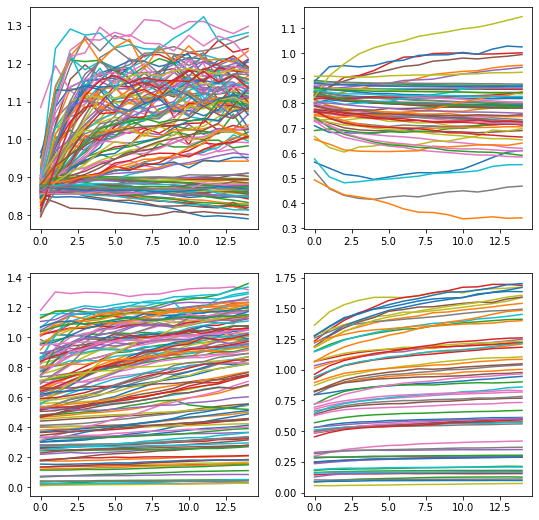

In [10]:
plt.figure(figsize=(9,9))

a0 = np.array(a0_list)
ax1 = plt.subplot(221)
ax1.plot(a0)

a1 = np.array(a1_list)
ax2 = plt.subplot(222)
ax2.plot(a1)

g0 = np.array(g0_list)
ax3 = plt.subplot(223)
ax3.plot(g0)

g1 = np.array(g1_list)
ax4 = plt.subplot(224)
ax4.plot(g1)

plt.show()

In [11]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        img = img.cuda(DEV)
        labels = labels.cuda(DEV)
        
        with torch.no_grad():
            logps = model(img)


        ps = torch.exp(logps)
        ps = ps.detach().cpu()
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.detach().cpu().numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9721
